# Impact of Scaling on Machine Learning Regression Algorithms

In this project, we will investigate how scaling the data impacts the performance of a variety of machine learning algorithms for prediction.

In particular we will look into
* Linear Regression and other linear models
* K-nearest Regression
* Decisition Tree Regression
* Support Vector Regression
* Bagging algorithms
* Boosting algorithms

For this project we will use the [`Auto MPG`](https://archive.ics.uci.edu/ml/datasets/Auto+MPG) data set. Please follow the instructions in the post [`Working with the Auto MPG Data Set`](./auto-mpg) to get yourself familiar with the dataset, prepare the data for analysis and generate the `auto-mpg.csv` that will be used in this project.

***
## 1. Loading and Inspecting the Data

In [4]:
import pandas as pd
filename = "auto-mpg.csv"
df = pd.read_csv(filename)

df.head(3)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite


This data set is typically used to learn and predict the `mpg` column. We will denote the remaining columns with numerical values as the feature space. In other words, this prediction problem has a 7-dimensional input space comprising of `cylinders`, `displacement`, `horsepower`, `weight`, `acceleration`, `year` and `origin` features. We will ignore the non-numerical `name` column in this project.  

At this point, we will separate the data into `output` (`mpg` column) and `features` (columns from `cylinders` to `origin`, excluding the `name` column). 

In [3]:
output = df.iloc[:,0]
features = df.iloc[:, 1:8]

In [19]:
pd.set_option('precision', 2)
# display stats of the features
features.describe()

,cylinders,displacement,horsepower,weight,acceleration,year,origin
count,398.00,398.00,398.00,398.00,398.00,398.00,398.00
mean,5.45,193.43,104.46,2970.42,15.57,76.01,1.57
std,1.70,104.27,38.20,846.84,2.76,3.70,0.80
min,3.00,68.00,46.00,1613.00,8.00,70.00,1.00
25%,4.00,104.25,76.00,2223.75,13.83,73.00,1.00
50%,4.00,148.50,95.00,2803.50,15.50,76.00,1.00
75%,8.00,262.00,125.00,3608.00,17.17,79.00,2.00
max,8.00,455.00,230.00,5140.00,24.80,82.00,3.00


There is a significant scale difference between the features as seen from the `min`, `max` values. Similarly, the mean values of the features range from 1.57 (`origin`) to 2970.26 (`weight`), almost a 1:2000 maximum ratio.

A visual display of the scale difference between the features is illustrated by the boxplot below.  

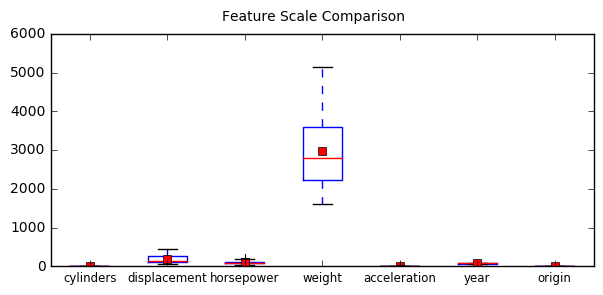

In [8]:
import matplotlib.pyplot as plt
import numpy as np

names = features.columns

def featureBoxPlot(X, names):
    # change figure size
    plt.rcParams["figure.figsize"] = [7, 3]
    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Feature Scale Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(X, showmeans=True)
    ax.set_xticklabels(names, fontsize=8.5)
    plt.show()
    return

featureBoxPlot(features.values, names)

This large discrepancy in the scaling of the feature space elements may cause critical issues in the process and performance of machine learning (ML) algorithms. In particular,

* Any ML algorithm that is based on a distance metric in the feature space will be greatly biased towards the feature with the largest or smallest feature. A typical example is the K-nearest neighbor regression algorithm which makes a prediction based on the *nearest* `K` elements in the data set. 

* Any feature selection method that relies on weighting parameters associated with an ML algorithm will be greatly biased towards the feature with the largest or the smallest scale. An example to this situation is the use of the coefficients that result from linear regression for ranking the features in terms of importance.

In this notebook we only focus on the impact of scaling on ML algorithms. Scaling impact on feature selection will be addressed in another notebook. 

***
## 2. Normalizing the Data

In this section we will normalize the feature data in two ways:
* rescale range to (0,1)
* standardize data so that variance is 1 and mean is zero.

The feature space will be represented by the matrix `X` and the output that we are trying to predict will be denoted by `y`. From now on we will use `numpy arrays` to represent our data.

In [9]:
X = features.values #Note that `features` is a dataframe, but `features.values` is a numpy array
y = output.values

### 2.1 Input normalization: rescaling to (0,1)

To scale the range to (0,1) the minimum value of the data is first subtracted from every element, and then the whole data is divided by the resulting maximum value. 

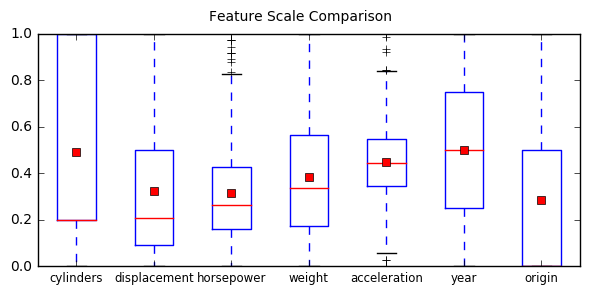

In [10]:
# Rescale data (between 0 and 1)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX = scaler.fit_transform(X)

featureBoxPlot(rescaledX, names)

It is clear from the above boxplot that all ranges are now the same (i.e., from 0 to 1) despite slightly varying means. 

### 2.2 Input normalization: standardizing to zero mean and unity variance

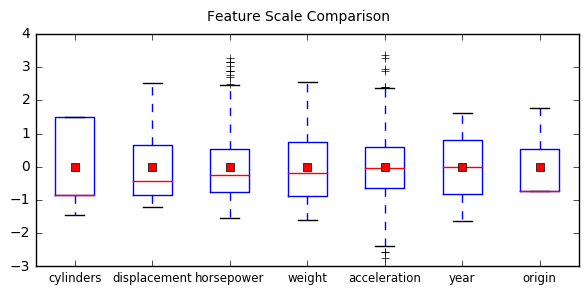

In [11]:
# Standardize data (0 mean, 1 stdev)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X)
standardizedX = scaler.transform(X)

featureBoxPlot(standardizedX, names)

In this case the means and the standard variations are the same but the ranges are slightly different. Note that all distributions are now centered around `0` and thus have positive and negative values. 

### 2.3 An important note

>The scaling parameters applied in this section were extracted from the whole data for simplicity reasons. Performance anaylsis done below using different ML algorithms, however, are based on a training and a test set partitioned off from the original data. Ideally, the scaling parameters should have been obtained only from the training data and applied on both the training and the test data sets. Using the whole data set to determine the scaling parameters introduces contamination into performance testing. Since we are only interested in the general trends regarding the impact of scaling on performance this contamination effect will be ignored. 

***
## 3. Test and Display Functions

We will use the following functions in the evaluation of the ML algorithms in the remaining of this notebook.

In [12]:
def scalingBoxPlot(results, names, modelname):
    # change figure size
    plt.rcParams["figure.figsize"] = [4, 2]
    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle(modelname)
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names, fontsize=9.5)
    plt.show()
    return

def runTest(scaling, model, scoring='r2', boxplotOn=True):
    modelname = str(model).partition('(')[0]
    kfold = KFold(n_splits=10, random_state=7, shuffle=True)
    # evaluate each test in turn
    results = []
    t_names = []
    for name, Xw in scaling:     
        cv_results = cross_val_score(model, Xw, y, cv=kfold, scoring=scoring)
        results.append(abs(cv_results))
        t_names.append(name)
    if boxplotOn:
        scalingBoxPlot(results, t_names, modelname)
    out_mean = np.array(results).mean(axis=1)
    return(out_mean)

***
## 4. Testing on common ML algorithms

The following settings are common to all testing done below. 

In [13]:
# Compare Algorithms
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# prepare test
inputTypes = ['original', 'scaled', 'standardized']
scaling = [('original', X), ('rescaled', rescaledX), ('standardized', standardizedX)]
out_mat = []
models = []
#scoring = 'neg_mean_squared_error'  
scoring = 'r2'

### 4.1 Linear Regression

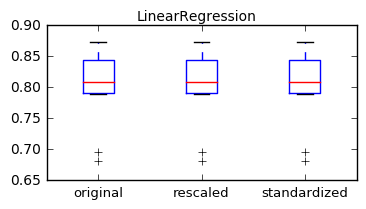

In [14]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
modelname = str(model).partition('(')[0]
out_mean = runTest(scaling, model, scoring)
models.append(modelname)
out_mat.append(out_mean)

The Linear Regression algorithm was not impacted by scaling as the coefficients of the linear weighting function is automatically adjusted to different scales. 

### 4.2 k-Nearest Neighbor Regression

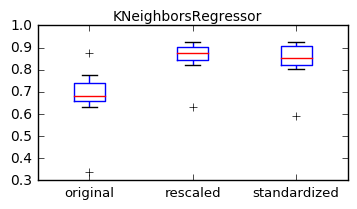

In [15]:
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor()
modelname = str(model).partition('(')[0]
out_mean = runTest(scaling, model, scoring)
models.append(modelname)
out_mat.append(out_mean)

The K-nearest Neigbors algorithm is clearly impacted by scaling as it is based on distance calculated in the feature space. When the data is not scaled properly features with large values are artificially demoted in the selection process. 

### 4.3 Decision Tree Regression

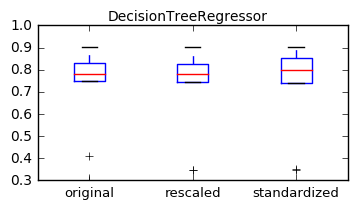

In [16]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
modelname = str(model).partition('(')[0]
out_mean = runTest(scaling, model, scoring)
models.append(modelname)
out_mat.append(out_mean)

The decision tree concept is fairly insensitive to scaling differences between features as the optimal decision to follow a certain branch or another is based on a value comparison against a threshold which automatically scales with the scale of the input data. 

### 4.4 Support Vector Regression

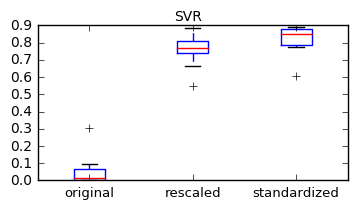

In [17]:
from sklearn.svm import SVR
model = SVR(kernel='rbf')
modelname = str(model).partition('(')[0]
out_mean = runTest(scaling, model, scoring)
models.append(modelname)
out_mat.append(out_mean)

Support Vector Machine (SVM) algorithm is impacted significantly if proper scaling is not applied as seen above. The very poor performance observed using the `original` data set warrants further study as it may point to an anomaly. It is generally reported that the SVM algorithm generally works better when normalized to a [-1, +1] range rather than the [0, +1] range which is also observed here. However, this is not well explained and may be due to the data set. 

### 4.5 Comparison of R² results

In [21]:
pd.set_option('precision', 3)
pd.DataFrame(out_mat, models, inputTypes)

,original,scaled,standardized
LinearRegression,0.799,0.799,0.799
KNeighborsRegressor,0.677,0.853,0.840
DecisionTreeRegressor,0.720,0.716,0.723
SVR,0.057,0.755,0.821


In summary, K-nearest Neighbor and Support Vector Machines algorithms which are distance based require proper scaling. On the other hand, Linear Regression and Decision Tree algorithms are immune to scaling differences in the feature set. No significant difference is observed generally between scaling to the (0,1) range and standardizing to zero mean and unit variance.

***
## 5. Testing on other Models

### 5.1 Linear Models

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

out_mat = []
models = []
Lmodels = [LinearRegression(), Ridge(), Lasso(), ElasticNet()]
for model in Lmodels:
    modelname = str(model).partition('(')[0]
    out_mean = runTest(scaling, model, scoring, boxplotOn=False)
    models.append(modelname)
    out_mat.append(out_mean)
    
pd.DataFrame(out_mat, models, inputTypes)

,original,scaled,standardized
LinearRegression,0.799,0.799,0.799
Ridge,0.799,0.794,0.799
Lasso,0.791,0.450,0.772
ElasticNet,0.791,0.339,0.740


### 5.2 Bagging Algorithms

In [23]:
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

out_mat = []
models = []
num_trees = 100
seed = 7
max_features = 7
Bmodels = [BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=num_trees, random_state=seed), 
           RandomForestRegressor(n_estimators=num_trees, max_features=max_features), 
           ExtraTreesRegressor(n_estimators=num_trees, max_features=max_features)]
for model in Bmodels:
    modelname = str(model).partition('(')[0]
    out_mean = runTest(scaling, model, scoring, boxplotOn=False)
    models.append(modelname)
    out_mat.append(out_mean)
    
pd.DataFrame(out_mat, models, inputTypes)

,original,scaled,standardized
BaggingRegressor,0.847,0.846,0.847
RandomForestRegressor,0.850,0.847,0.849
ExtraTreesRegressor,0.854,0.854,0.854


It is not surprising to see impact of scaling on bagging algorithms to be negligible since they are all decision-tree based. 

### 5.3 Boosting Algorithms

In [24]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

out_mat = []
models = []
num_trees = 100
seed = 7
BSTmodels = [AdaBoostRegressor(n_estimators=num_trees, random_state=seed), 
             GradientBoostingRegressor(n_estimators=num_trees, random_state=seed)]
for model in BSTmodels:
    modelname = str(model).partition('(')[0]
    out_mean = runTest(scaling, model, scoring, boxplotOn=False)
    models.append(modelname)
    out_mat.append(out_mean)
    
pd.DataFrame(out_mat, models, inputTypes)

,original,scaled,standardized
AdaBoostRegressor,0.825,0.821,0.825
GradientBoostingRegressor,0.851,0.850,0.851


Similar observation for boosting algorithms: they are decision-tree based and insensitive to input scaling. 

***
## 6. Summary

The following algorithms are sensitive to scaling differences in the feature space:
* Support Vector Machines regression
* K-nearest Neighbors regression
* Lasso and ElasticNet linear regression models

The rest of the ML methods studied were found the be immune to input scaling:
* Standard and Ridge linear regression models
* Decision Tree Regression
* Bagging Algorithms
* Boosting Algorithms